In [1]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
pd.options.display.max_columns = None
#from pybaseball import batting_stats, batting_stats_range, pitching_stats_range, cache, playerid_lookup, statcast_batter, statcast_pitcher, statcast
import math
import sqlite3
#from fantasy_utils import Fantasy_Projections
import fantasy_utils as fu
import optimize_lineup as ol
import time
#cache.enable()
#cache.config.cache_type='csv'
#cache.config.save()

In [2]:
fp = fu.Fantasy_Projections()
#df = fp.make_projections(fp.yr)

In [3]:
# Download latest Chrome driver
#https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json

In [3]:
conn = sqlite3.connect('fantasy_data.db')
#conn.create_function('sqrt', 1, math.sqrt)
#cursor = conn.cursor()

In [4]:
def safe_sqrt(x):
    try:
        return math.sqrt(x)
    except ValueError:
        return None  # or some other appropriate value or handling

conn.create_function('sqrt', 1, safe_sqrt)


In [5]:
import logging
logging.basicConfig(level=logging.DEBUG)

def safe_sqrt(x):
    try:
        return math.sqrt(x)
    except Exception as e:
        logging.error(f"Error computing sqrt for {x}: {e}")
        return None  # or some other appropriate value or handling

conn.create_function('sqrt', 1, safe_sqrt)


In [7]:
pd.read_sql("SELECT * FROM vw_player_year_z WHERE year=2025", conn)

,year,cbsid,zR,zRBI,zHR,zSB,zBA,zHit,zW,zSO,zSvHld,zERA,zWHIP,zPitch,z,SvHld


In [5]:
#keepers Google doc
keepers_url = 'https://docs.google.com/spreadsheets/d/1dwDC2uMsfVRYeDECKLI0Mm_QonxkZvTkZTfBgnZo7-Q/edit#gid=1723951361'

In [10]:
from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [9]:
ids = fp.load_id_map()

In [8]:
pd.read_sql("SELECT name FROM sqlite_master", conn)

,name
0,hitting
1,ix_hitting_index
2,hitters
3,sqlite_autoindex_hitters_1
4,players2022
5,owners
6,drafted
7,roster
8,stats
9,players2023


## Create Tables 

### owners
Create owners table with id and name fields

In [6]:
owner_dict = {"owner_id":[30, 3, 36, 41, 4, 27, 38, 44, 1, 29, 42, 45, 47],
              "owner":["9 Grand Kids", 'Brewbirds', 'Charmer', 'Dirty Birds', "Harveys Wallbangers", 'Lil Trump & the Ivanabees', 'Lima Time!', 'Roid Ragers', 'Trouble with the Curve', 'Ugly Spuds', 'Wiscompton Wu-Tang', 'Young Guns', "Mom's Cookin"],
             }

In [7]:
owners = pd.read_sql("SELECT * FROM owners", engine)
owners

NameError: name 'engine' is not defined

In [ ]:
# Uncomment below line to overwrite owners table
#pd.DataFrame(owner_dict).to_sql("owners", con=engine, if_exists='append', index=False)

In [112]:
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
conn = engine.connect()
params = [
    {'owner_id': 47, 'owner':"Mom's Cookin"},
]

stmt = text("INSERT INTO owners VALUES(:owner_id, :owner)")
#stmt = text("DELETE FROM players WHERE CBSNAME='Jung Hoo Lee'")
conn.execute(stmt, params)
conn.commit()
conn.close()

### roster

In [ ]:
ros = pd.read_excel('data//2023-owner-weekly-sit-start.xlsx')
owners = pd.read_sql('owners', engine)
ros = ros.merge(owners, left_on='Owner', right_on='owner', how='outer', indicator=True)
ros.loc[ros['Decision']=='Sit', 'Pos'] = 'B'
ros.loc[ros['Decision']=='Start', 'Decision'] = 1
ros.loc[ros['Decision']=='Sit', 'Decision'] = 0

In [ ]:
ros.info()

In [ ]:
ros.value_counts('_merge')

In [ ]:
pd.pivot_table(ros,index='owner', columns='Week', aggfunc='count', values='CBSID')

In [ ]:
ros[ros['Decision']==1].Pos.value_counts()

In [ ]:
ros.rename(columns={'CBSID':'cbsid', 'Year':'year', 'Week':'week', 'Pos':'pos'},inplace=True)

In [ ]:
# Uncomment below to append to roster table
ros[['cbsid', 'owner_id', 'year', 'week', 'pos']].to_sql('roster', index=False, if_exists='replace', con=engine)

In [ ]:
pd.read_sql('roster', engine)

### players

In [11]:
pd.read_sql("SELECT name FROM sqlite_master", engine)

,name
0,hitting
1,ix_hitting_index
2,hitters
3,sqlite_autoindex_hitters_1
4,players2022
5,owners
6,drafted
7,roster
8,stats
9,players2023


In [ ]:
#cursor.execute("CREATE TABLE players2023 AS SELECT * FROM players;").commit()

In [12]:
p = pd.read_sql('players',engine)
p.rename(columns={'Owner':'owner', 'Paid':'paid', 'Keeper':'keeper','Timestamp':'timestamp'},inplace=True)
p.rename(columns={'CBSID':'cbsid'},inplace=True)
p['year'] = datetime.now().year
p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cbsid           3451 non-null   float64
 1   CBSNAME         3561 non-null   object 
 2   IDPLAYER        3234 non-null   object 
 3   PLAYERNAME      3236 non-null   object 
 4   BIRTHDATE       3234 non-null   object 
 5   FIRSTNAME       3234 non-null   object 
 6   LASTNAME        3234 non-null   object 
 7   TEAM            2174 non-null   object 
 8   LG              2173 non-null   object 
 9   POS             3234 non-null   object 
 10  IDFANGRAPHS     3234 non-null   object 
 11  FANGRAPHSNAME   3236 non-null   object 
 12  MLBID           3234 non-null   float64
 13  MLBNAME         3233 non-null   object 
 14  RETROID         2227 non-null   object 
 15  BREFID          3232 non-null   object 
 16  NFBCID          2427 non-null   float64
 17  NFBCNAME        3230 non-null   o

In [79]:
pd.read_sql("SELECT p.cbsid, p.CBSNAME, p.playername, p.idfangraphs, p2.Name, p2.playerid, p2.Owner \
    FROM players2024 p2 LEFT JOIN players p On (p.IDFANGRAPHS=p2.playerid) \
    WHERE p2.Owner IS NOT NULL AND p.cbsid IS NULL", engine)#[['IDFANGRAPHS', 'cbsid', 'Name']].to_dict(orient='records')

,cbsid,CBSNAME,PLAYERNAME,IDFANGRAPHS,Name,playerid,Owner
0,None,None,None,None,Yoshinobu Yamamoto,sa3023345,Brewbirds
1,None,None,None,None,Wyatt Langford,sa3022654,Charmer
2,None,None,None,None,Shota Imanaga,sa3023346,Lima Time
3,None,None,None,None,Jackson Chourio,sa3015704,Young Guns
4,None,None,None,None,Jackson Holliday,sa3020241,Young Guns
5,None,None,None,None,Colt Keith,sa3014474,Brewbirds
6,None,None,None,None,Jackson Merrill,sa3016829,Harvey
7,None,None,None,None,Tyler Black,sa3017623,Roid Ragers
8,None,None,None,None,James Wood,sa3016870,Ugly Spuds
9,None,None,None,None,Paul Skenes,sa3023079,Ugly Spuds


In [100]:
pd.read_sql("SELECT * FROM players WHERE FANGRAPHSNAME IS NULL AND cbsid=26912489.0", conn)

,cbsid,CBSNAME,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST,ACTIVE
0,26912489.0,Abner Uribe,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [103]:
params = pd.read_sql("SELECT CBSNAME, CAST(min(cbsID) AS int) min_cbsid, max(cbsid) max_cbsid, count(cbsid) dups, \
    count(FANGRAPHSNAME), max(FANGRAPHSNAME) max_fg_name \
    FROM players GROUP BY CBSNAME \
    HAVING count(cbsid) > 1 AND count(FANGRAPHSNAME)<count(cbsid) AND min_cbsid=max_cbsid", conn).to_dict(orient='records')
params

[{'CBSNAME': 'Abner Uribe',
  'min_cbsid': 26912489,
  'max_cbsid': 26912489.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Abner Uribe'},
 {'CBSNAME': 'Andrew Nardi',
  'min_cbsid': 2837279,
  'max_cbsid': 2837279.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Andrew Nardi'},
 {'CBSNAME': 'Bryan Woo',
  'min_cbsid': 29075489,
  'max_cbsid': 29075489.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Bryan Woo'},
 {'CBSNAME': 'Cody Bradford',
  'min_cbsid': 26911814,
  'max_cbsid': 26911814.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Cody Bradford'},
 {'CBSNAME': 'Cristopher Sanchez',
  'min_cbsid': 3151554,
  'max_cbsid': 3151554.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Cristopher Sanchez'},
 {'CBSNAME': 'Emmet Sheehan',
  'min_cbsid': 29075539,
  'max_cbsid': 29075539.0,
  'dups': 2,
  'count(FANGRAPHSNAME)': 1,
  'max_fg_name': 'Emmet Sheehan'},
 {'CBSNAME': 'Evan Carter',
  'min_cbsid': 26615381,
 

In [104]:
params = pd.read_sql("SELECT CBSNAME, CAST(min(cbsID) AS int) min_cbsid, max(cbsid) max_cbsid, count(cbsid) dups, \
    count(FANGRAPHSNAME), max(FANGRAPHSNAME) max_fg_name \
    FROM players GROUP BY CBSNAME \
    HAVING count(cbsid) > 1 AND count(FANGRAPHSNAME)<count(cbsid) AND min_cbsid=max_cbsid", conn).to_dict(orient='records')

stmt = "DELETE FROM players WHERE cbsid=:min_cbsid AND FANGRAPHSNAME IS NULL"

cursor = conn.cursor()

for param in params:
    cursor.execute(stmt, param)

conn.commit()
print(stmt)

DELETE FROM players WHERE cbsid=:min_cbsid AND FANGRAPHSNAME IS NULL


#### Add new players

In [106]:
fp = fu.Fantasy_Projections()
ids = fp.load_id_map()

In [109]:
ids[ids['CBSNAME'].isin([''])][['CBSNAME', 'CBSID', 'IDFANGRAPHS']]

,CBSNAME,CBSID,IDFANGRAPHS
1706,Joey Loperfido,28839913.0,29630


In [111]:
params = [
    {'IDFANGRAPHS': '29630', 'cbsid':28839913., 'Name': 'Joey Loperfido'},
]

stmt = "INSERT INTO players (cbsid, CBSNAME, IDFANGRAPHS) VALUES (:cbsid, :Name, :IDFANGRAPHS)"

cursor = conn.cursor()

for param in params:
    cursor.execute(stmt, param)

conn.commit()

In [73]:
stmt = text("INSERT INTO players ('IDFANGRAPHS', 'FANGRAPHSNAME', 'cbsid', 'CBSNAME', 'PLAYERNAME') VALUES ('sa3003222', 'Aldenis Sanchez', 2829128, 'Aldenis Sanchez', 'Aldenis Sanchez')")

In [57]:
pd.read_sql("SELECT * FROM players where CBSNAME='Aldenis Sanchez'", engine)

,cbsid,CBSNAME,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,MLBID,MLBNAME,RETROID,BREFID,NFBCID,NFBCNAME,ESPNID,ESPNNAME,BPID,YAHOOID,YAHOONAME,MSTRBLLNAME,BATS,THROWS,FANTPROSNAME,LASTCOMMAFIRST,ROTOWIREID,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST,ACTIVE
0,2829128.0,Aldenis Sanchez,None,Aldenis Sanchez,None,None,None,None,None,None,sa3003222,Aldenis Sanchez,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [44]:
#ids[p.drop(columns=['cbsid', 'year']).columns][ids['IDFANGRAPHS'].isin(['sa3023345', 'sa3012640', 'sa3023346', 'sa3023348', '25942', '17722', 'sa3021053', 'sa3014709', 'sa3003222'])].to_sql('players', index=False, con=engine, if_exists='append')

7

### drafted

In [109]:
pd.read_sql("SELECT * FROM owners", engine)

,owner_id,owner
0,30,9 Grand Kids
1,3,Brewbirds
2,36,Charmer
3,41,Dirty Birds
4,4,Harveys Wallbangers
5,27,Lil Trump & the Ivanabees
6,38,Lima Time!
7,44,Roid Ragers
8,1,Trouble with the Curve
9,29,Ugly Spuds


In [171]:
df = pd.read_sql('SELECT pp.CBSNAME, pp.cbsid, p.Owner, p.Paid paid, p.Supp, p.TimeStamp timestamp, p.Keeper keeper, 2024 year \
    FROM players2024 p \
    INNER JOIN players pp On (p.playerid=pp.IDFANGRAPHS) \
    WHERE p.Owner IS NOT NULL', engine)
df.Owner.replace({'Harvey':'Harveys Wallbangers', 'Lima Time':'Lima Time!', 'Wu-Tang':'Wiscompton Wu-Tang', 'Madness':'9 Grand Kids', 'Midnight':'9 Grand Kids', 'Trouble':'Trouble with the Curve', 'Mother':'Mom\'s Cookin', 'Lil Trump':'Lil Trump & the Ivanabees'},inplace=True)
df = df.merge(owners, left_on='Owner', right_on='owner', how='left')
df.drop(columns=['Owner', 'Supp', 'owner'],inplace=True)
df['cbsid'] = df['cbsid'].astype(int)
df['keeper'] = df['keeper'].astype(int)
df['timestamp'] = df.timestamp.apply(lambda x: datetime.strftime(pd.to_datetime(x), '%Y-%m-%d %H:%M:%S'))
df.head()

,CBSNAME,cbsid,paid,timestamp,keeper,year,owner_id
0,Ronald Acuna,2211777,46,2024-02-20 08:15:00,1,2024,42
1,Bobby Witt,3117472,30,2024-01-26 13:22:00,1,2024,1
2,Shohei Ohtani,2901324,41,2024-03-16 09:34:46,0,2024,36
3,Aaron Judge,2071264,34,2024-03-16 09:54:11,0,2024,44
4,Fernando Tatis,2507363,34,2024-02-04 08:15:00,1,2024,4


In [153]:
# Uncomment to append to drafted table
#df[['cbsid', 'owner_id','year','paid', 'timestamp', 'keeper']].to_sql('drafted', if_exists='append', index=False, con=engine)

397

In [172]:
df[df['owner_id']==38].sort_values('cbsid')

,CBSNAME,cbsid,paid,timestamp,keeper,year,owner_id
180,Justin Verlander,530362,7,2024-03-16 14:46:39,0,2024,38
249,Jason Adam,1846226,0,2024-03-17 08:08:22,0,2024,38
82,Brandon Nimmo,1894663,11,2024-03-16 11:58:20,0,2024,38
55,Xander Bogaerts,1945481,15,2024-03-16 10:55:03,0,2024,38
120,Trevor Story,1945488,5,2024-03-16 10:11:37,0,2024,38
70,Marcell Ozuna,1953522,13,2024-03-16 13:02:00,0,2024,38
391,Jacob deGrom,2044508,0,2024-03-22 12:42:09,0,2024,38
48,Teoscar Hernandez,2119659,17,2024-03-16 12:25:39,0,2024,38
78,Alex Bregman,2184351,18,2024-03-16 11:32:39,0,2024,38
9,Kyle Tucker,2184352,40,2024-03-16 09:59:38,0,2024,38


In [16]:
engine = create_engine('sqlite:///fantasy_data.db', echo=False)
conn = engine.connect()
stmt = text("DELETE FROM players WHERE cbsid=26643926 AND IDFANGRAPHS IS NULL")
#conn.execute(stmt)
#conn.commit()
conn.close()

In [173]:
pd.read_sql('drafted', engine)

,cbsid,owner_id,year,paid,timestamp,keeper
0,389743,3,2023,0,2023-10-08 10:40:02.685131,0
1,479065,30,2023,1,2023-10-08 10:28:06.951107,0
2,530355,3,2023,1,2023-10-08 10:31:09.856439,0
3,530362,38,2023,25,2023-10-08 09:19:24.065713,0
4,547421,3,2023,0,2023-10-08 10:46:09.198658,0
...,...,...,...,...,...,...
785,2044508,38,2024,0,2024-03-22 12:42:09.000000,0
786,29153541,29,2024,0,2024-03-22 12:42:36.000000,0
787,29075709,42,2024,1,2024-03-22 12:44:53.000000,0
788,26615406,41,2024,0,2024-03-22 12:43:53.000000,0


### eligibility

In [8]:
# Remove DH values that erroneously existed for pitchers
elig = pd.read_sql("SELECT p.CBSNAME, e.cbsid, e.year, e.week, e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, \
        CASE WHEN posDH >= 5 THEN 5 \
            WHEN posC >= 5 THEN 5 \
            WHEN pos1B >= 5 THEN 5 \
            WHEN pos2B >= 5 THEN 5 \
            WHEN pos3B >= 5 THEN 5 \
            WHEN posSS >= 5 THEN 5 \
            WHEN posOF >= 5 THEN 5 \
            WHEN posMI >= 5 THEN 5 \
            WHEN posCI >= 5 THEN 5 \
            ELSE 0 END posDH, \
        e.posSP, e.posRP, \
        CASE WHEN e.posP >= 5 THEN 5 \
            WHEN e.posSP >= 5 THEN 5 \
            WHEN e.posRP >= 5 THEN 5 \
            ELSE 0 END posP \
        FROM eligibility e \
        LEFT JOIN players p ON (e.cbsid=p.cbsid) \
        WHERE e.year=2024 AND p.CBSNAME!='Shohei Ohtani'", conn)
remove_dh = elig[(elig['posP']>=5) & (elig['posDH']>=5)]
remove_dh.loc[remove_dh['posP']>=5, 'posDH'] = 0

cursor = conn.cursor()

params = remove_dh.to_dict(orient='records')
stmt = "UPDATE eligibility SET posDH = :posDH WHERE cbsid = :cbsid AND year = :year and week = :week"

for param in params:
    cursor.execute(stmt, param)

conn.commit()

C:\Users\pddnh\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
# Update all_pos to match what each position says
elig = pd.read_sql("SELECT p.CBSNAME, e.cbsid, e.year, e.week, e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, \
        CASE WHEN posDH >= 5 THEN 5 \
            WHEN posC >= 5 THEN 5 \
            WHEN pos1B >= 5 THEN 5 \
            WHEN pos2B >= 5 THEN 5 \
            WHEN pos3B >= 5 THEN 5 \
            WHEN posSS >= 5 THEN 5 \
            WHEN posOF >= 5 THEN 5 \
            WHEN posMI >= 5 THEN 5 \
            WHEN posCI >= 5 THEN 5 \
            ELSE 0 END posDH, \
        e.posSP, e.posRP, \
        CASE WHEN e.posP >= 5 THEN 5 \
            WHEN e.posSP >= 5 THEN 5 \
            WHEN e.posRP >= 5 THEN 5 \
            ELSE 0 END posP \
        FROM eligibility e \
        LEFT JOIN players p ON (e.cbsid=p.cbsid) \
        WHERE e.year=2024", conn)

elig[[p for p in elig.columns if p.startswith('pos') and len(p)>3]] = elig[[p for p in elig.columns if p.startswith('pos') and len(p)>3]].fillna(0)
elig.all_pos = ''
for pos in [p for p in elig.columns if p.startswith('pos') and len(p)>3]:
    elig.loc[elig[pos]>=5, 'all_pos'] += pos.replace('pos','')+','

elig['all_pos'] = elig['all_pos'].apply(lambda x: x[:-1])

# Update statement
cursor = conn.cursor()

params = elig[['cbsid', 'year', 'week', 'all_pos']].to_dict(orient='records')
stmt = "UPDATE eligibility SET all_pos = :all_pos WHERE cbsid = :cbsid AND year = :year and week = :week"

for param in params:
    cursor.execute(stmt, param)

conn.commit()

In [10]:
pd.read_sql("SELECT p.CBSNAME, e.* FROM eligibility e INNER JOIN players p On (p.cbsid=e.cbsid) WHERE year=2024", conn)

,CBSNAME,cbsid,year,week,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP
0,Ronald Acuna,2211777,2024,1,"OF,DH",0,0,0,0,0,0,0,5,5,0,0,0
1,Shohei Ohtani,2901324,2024,1,"DH,P",0,0,0,0,0,0,0,0,5,0,0,5
2,Aaron Judge,2071264,2024,1,"OF,DH",0,0,0,0,0,0,0,5,5,0,0,0
3,Mookie Betts,2106654,2024,1,"2B,SS,MI,OF,DH",0,0,5,0,5,5,0,5,5,0,0,0
4,Corbin Carroll,3117913,2024,1,"OF,DH",0,0,0,0,0,0,0,5,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6941,Paul Goldschmidt,1765052,2024,20,"1B,CI,DH",0,99,0,0,0,0,99,0,3,0,0,0
6942,Tyler Anderson,1894636,2024,20,"SP,P",0,0,0,0,0,0,0,0,0,21,0,5
6943,Max Fried,2001078,2024,20,"SP,P",0,0,0,0,0,0,0,0,0,18,0,5
6944,Starling Marte,1741213,2024,20,"OF,DH",0,0,0,0,0,0,0,60,6,0,0,0


In [ ]:
df = pd.read_excel('data//2023-weekly-stats-h.xlsx')
df2 = pd.read_excel('data//2023-weekly-stats-p.xlsx')

In [ ]:
el = pd.DataFrame()
for period in range(1,28):
    if period < 14:
        p = pd.read_csv(f'C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\data\\period_14_projections.csv')
        #p['year'] = 2023
        #p['week'] = period
    elif period == 24:
        p = pd.read_csv(f'C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\data\\period_23_projections.csv')
        #p['year'] = 2023
        #p['week'] = period
    else:
        p = pd.read_csv(f'C:\\Users\\pddnh\\Documents\\GitHub\\baseball\\data\\period_{period}_projections.csv')
    p['year'] = 2023
    p['week'] = period
    el = pd.concat([el, p])

In [ ]:
players = pd.read_sql("SELECT * from players", conn)

In [ ]:
el[['Player', 'Owner', 'year', 'week', 'Start', 'type', 'all_pos', 'C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF', 'DH', 'SP', 'RP', 'P']]\
    .merge(e[['cbsid', 'CBSNAME', 'week']], left_on=['Player', 'week'], right_on=['CBSNAME', 'week'], how='left').sort_values('cbsid')

In [ ]:
e = pd.read_sql('SELECT e.*, p.CBSNAME FROM eligibility e left join players p On (e.cbsid=p.cbsid)', conn)
e.head()

In [11]:
for item in e[(e['all_pos'].str.contains('P')) & (e['posP']==0)]['all_pos'].unique():
    if 'DH' in item:
        print(item.replace(", 'P'",''))
        e.loc[e['all_pos']==item, 'all_pos'] = item.replace(", 'P'",'')
    else:
        e.loc[e['all_pos']==item, 'all_pos'] = item.replace('P','DH')
        print(item.replace('P','DH'))

NameError: name 'e' is not defined

In [ ]:
for t in ['posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']:
    e[t] = 0

In [ ]:
for n in range(len(e)):
    #e.loc[e.index==n, ['posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']] = [0,0,0,0,0,0,0,0,0,0,0,0]
    for i in e['all_pos'].iloc[n].replace('[','').replace(']','').replace("'",'').replace(' ','').split(','):
        #print(i)
        e.loc[e.index==n, 'pos'+i] = 1
    


In [ ]:
e

In [ ]:
n = 89
for i in e['all_pos'].iloc[n].replace('[','').replace(']','').replace("'",'').replace(' ','').split(','):
    print('pos'+i)
    e.loc[e.index==n, 'pos'+i] = 1

In [ ]:
e['all_pos'].iloc[89].replace('[','').replace(']','').replace("'",'').replace(' ','').split(',')

In [ ]:
n = 89
#e.loc[e.index==n, ['posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']] = [0,0,0,0,0,0,0,0,0,0,0,0]
e.iloc[n]

In [ ]:
e[e['CBSNAME']=='Joey Votto']

In [ ]:
e.iloc[7940]['all_pos']

In [ ]:
df2['all_pos'] = "['P']"
df2.loc[df2['CBSID']==2901324, 'all_pos'] = "['DH', 'P']"

In [ ]:
df2[(df2['CBSID'].notna()) & (df2['Decision']!=0)][['Player', 'CBSID', 'CBSNAME', 'Pos', 'all_pos']]

In [ ]:
df2 = df2[(df2['CBSID']==2901324) & (df2['Decision']!=0) | (df2['CBSID']!=2901324)]

In [ ]:
df3 = pd.concat([df, df2])
df3 = df3[df3['Owner']!='FA']
df3['year'] = 2023
df3.rename(columns={'CBSID':'cbsid', 'Week':'week'}, inplace=True)

In [ ]:
df3 = df3.sort_values(['cbsid','week'])

In [ ]:
df3.loc[(df3['CBSNAME']=='Will Smith') & (df3['Owner']=='Ugly Spuds'), 'all_pos'] = "['C', 'DH']"

In [ ]:
df3['cbsid'] = df3['cbsid'].astype(int)

In [ ]:
df3.loc[df3['CBSNAME']==0, 'cbsid'] = 2120231

In [ ]:
df3[df3['CBSNAME']=='Shohei Ohtani'][['cbsid', 'CBSNAME', 'year', 'week', 'all_pos']]

In [ ]:
df3.groupby('CBSNAME')['week'].count().sort_values()

In [ ]:
df3.shape[0]/12/27

In [ ]:
e = pd.read_sql('select * from eligibility', engine)

#for pos in ['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF', 'DH', 'SP', 'RP', 'P']:
#    e[pos] = e.all_pos.apply(lambda x: 1 if pos in x else 0)
#e.rename(columns={i:'pos'+i for i in ['C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF', 'DH', 'SP', 'RP', 'P']},inplace=True)

In [ ]:
position_priority = ['posC', 'pos2B', 'pos3B', 'posSS', 'posOF', 'pos1B', 'posMI', 'posCI', 'posDH', 'posSP', 'posRP']
def stitch_positions(row):
    pos_code = row[position_priority+['posP']]>=1
    return str([i.replace('pos','') for i in list(pos_code[pos_code].index)])

In [ ]:
stitch_positions(e.iloc[10620,4:-1])

In [ ]:
e['all_pos2'] = e.apply(lambda x: stitch_positions(x),axis=1)

In [ ]:
e[e['all_pos']!=e['all_pos2']]

In [ ]:
e.columns

In [ ]:
pd.read_sql('SELECT * FROM eligibility where cbsid=2901324', conn)

In [ ]:
s = e.duplicated(['cbsid', 'week'])
s[s]

In [ ]:
e.drop_duplicates(['cbsid', 'week'])

In [ ]:
e[e.index.isin(s[s].values)]

In [ ]:
# Uncomment to append to eligibility
#e.sort_values(['cbsid', 'year', 'week']).drop(columns='CBSNAME').to_sql('eligibility', if_exists='replace', con=conn, index=False)

### stats

In [ ]:
#df = pd.read_excel('data//2023-weekly-stats-h.xlsx')
#df2 = pd.read_excel('data//2023-weekly-stats-p.xlsx')
df2 = df2[(df2['CBSID']==2901324) & (df2['Decision']!=0) | (df2['CBSID']!=2901324)]

In [61]:
owners_dict

NameError: name 'owners_dict' is not defined

In [60]:
pd.read_excel(r"data/2024-Harveys Wallbangers-sit-start.xlsx")

,CBSNAME,Owner,week,Team,pos,Decision,cbsid,MLBID,IDFANGRAPHS,year,owner_id
0,Francisco Alvarez,Harveys Wallbangers,1,NYM,C,Start,3152036,682626.0,26121.0,2024,4
1,Triston Casas,Harveys Wallbangers,1,BOS,1B,Start,2942989,671213.0,22514.0,2024,4
2,Jose Altuve,Harveys Wallbangers,1,HOU,2B,Start,1839905,514888.0,5417.0,2024,4
3,Jake Burger,Harveys Wallbangers,1,MIA,3B,Start,2835063,669394.0,22275.0,2024,4
4,C.J. Abrams,Harveys Wallbangers,1,WAS,SS,Start,3117475,682928.0,25768.0,2024,4
...,...,...,...,...,...,...,...,...,...,...,...
424,Hunter Greene,Harveys Wallbangers,13,CIN,SP,Sit,2835054,668881.0,22182.0,2024,4
425,Jared Jones,Harveys Wallbangers,13,PIT,SP,Sit,26615394,NaN,NaN,2024,4
426,Triston McKenzie,Harveys Wallbangers,13,CLE,SP,Sit,2431359,663474.0,18000.0,2024,4
427,Kodai Senga,Harveys Wallbangers,13,NYM,SP,Sit,29046609,673540.0,31838.0,2024,4


In [59]:
pd.read_sql("SELECT * FROM roster WHERE decision is null", conn)#.pos.value_counts()

,cbsid,owner_id,year,week,pos,decision


In [ ]:
df[df['Owner']!='FA'].shape, df2[df2['Owner']!='FA'].shape

In [ ]:
df.shape, df2.shape

In [ ]:
df2.sort_values('CBSID')

### optimized lineups

In [5]:
z = pd.read_sql("WITH cte As (\
            SELECT e.cbsid cbsid_e, MAX(p.CBSNAME) name, MAX(e.week) maxWeek, max(e.all_pos) all_pos, max(e.pos1B) pos1B, max(pos2B) pos2B, max(pos3B) pos3B, max(posSS) posSS, \
                max(posMI) posMI, max(posCI) posCI, max(posOF) posOF, max(posDH) posDH, max(posSP) posSP, max(posRP) posRP, max(posP) posP \
            FROM eligibility e \
            INNER JOIN players p on (e.cbsid=p.cbsid) \
            GROUP BY e.cbsid) \
            SELECT d.cbsid, COALESCE(p.CBSNAME, 'DNP') Player, o.owner Owner, COALESCE(d.paid,0) paid, ROUND(COALESCE(z,-19)*4.18,1) value, \
                ROUND(COALESCE(z,-19)*4.18-d.paid,1) surplus, ROUND(COALESCE(z,-19),2) z, \
                R, RBI, HR, SB, AB, H, Ha, BBa, ER, BA_cnt, BA, IP, W, SO, t.SvHld, ERA, ERA_cnt, WHIP, WHIP_cnt, zR, zRBI, zHR, zSB, zBA, d.year, cte.*, 0 As optimized \
            FROM drafted d \
            LEFT JOIN players p On (d.cbsid=p.cbsid) \
            LEFT JOIN owners o On (d.owner_id=o.owner_id) \
            LEFT JOIN vw_players_season_z z On (p.cbsid=z.cbsid) \
            LEFT JOIN vw_player_totals t On (z.cbsid=t.cbsid) \
            LEFT JOIN cte On (d.cbsid=cte.cbsid_e) \
            LEFT JOIN eligibility e On (cte.cbsid_e=e.cbsid AND cte.maxWeek=e.week) \
            ORDER BY z desc", conn)
z.loc[z.all_pos.isna(), 'all_pos'] = ''
z['type'] = z.all_pos.apply(lambda x: 'h' if 'DH' in x else 'p')
z.loc[z.all_pos=='', 'type'] = 'o'
z

DatabaseError: Execution failed on sql 'WITH cte As (            SELECT e.cbsid cbsid_e, MAX(p.CBSNAME) name, MAX(e.week) maxWeek, max(e.all_pos) all_pos, max(e.pos1B) pos1B, max(pos2B) pos2B, max(pos3B) pos3B, max(posSS) posSS,                 max(posMI) posMI, max(posCI) posCI, max(posOF) posOF, max(posDH) posDH, max(posSP) posSP, max(posRP) posRP, max(posP) posP             FROM eligibility e             INNER JOIN players p on (e.cbsid=p.cbsid)             GROUP BY e.cbsid)             SELECT d.cbsid, COALESCE(p.CBSNAME, 'DNP') Player, o.owner Owner, COALESCE(d.paid,0) paid, ROUND(COALESCE(z,-19)*4.18,1) value,                 ROUND(COALESCE(z,-19)*4.18-d.paid,1) surplus, ROUND(COALESCE(z,-19),2) z,                 R, RBI, HR, SB, AB, H, Ha, BBa, ER, BA_cnt, BA, IP, W, SO, t.SvHld, ERA, ERA_cnt, WHIP, WHIP_cnt, zR, zRBI, zHR, zSB, zBA, d.year, cte.*, 0 As optimized             FROM drafted d             LEFT JOIN players p On (d.cbsid=p.cbsid)             LEFT JOIN owners o On (d.owner_id=o.owner_id)             LEFT JOIN vw_players_season_z z On (p.cbsid=z.cbsid)             LEFT JOIN vw_player_totals t On (z.cbsid=t.cbsid)             LEFT JOIN cte On (d.cbsid=cte.cbsid_e)             LEFT JOIN eligibility e On (cte.cbsid_e=e.cbsid AND cte.maxWeek=e.week)             ORDER BY z desc': no such table: vw_players_season_z

In [6]:
z.cbsid.nunique()

NameError: name 'z' is not defined

In [ ]:
for o in owner_dict['owner']:
    opt = ol.Optimized_Lineups(o, z[z['Owner']==o])
    opt._make_hitter_combos()
    opt._make_pitcher_combos()
    print(opt.hitter_optimized_z, '\n', opt.pitcher_optimized_z)
    print(opt.hitter_optimized_lineup,'\n',opt.pitcher_optimized_lineup)
    z.loc[z['Player'].isin(opt.hitter_optimized_lineup), 'optimized'] = 1
    z.loc[z['Player'].isin(opt.pitcher_optimized_lineup), 'optimized'] = 1

In [ ]:
d = {   
    '9 Grand Kids':{'h':3.4, 'p':10.1},
    'Brewbirds':{'h':14.4, 'p':17.0},
    'Charmer':{'h':27.3,'p':25.4},
    'Dirty Birds':{'h':-16.4,'p':24.1},
    'Harveys Wallbangers':{'h':14.3,'p':-1.8},
    'Lil Trump & the Ivanabees':{'h':-17.4,'p':28.2},
    'Lima Time!':{'h':3.1,'p':23.2},
    'Roid Ragers':{'h':-17.9,'p':16.7},
    'Trouble with the Curve':{'h':15.0,'p':28.7},
    'Ugly Spuds':{'h':-10.5,'p':9.0},
    'Wisompton Wu-Tang':{'h':8.2,'p':27.3},
    'Young Guns':{'h':-23.3,'p':19.0},
}

In [ ]:
pd.DataFrame(d).T.h

In [ ]:
for i,j in d.items():
    print(i, round(j['h']+j['p'],1))

In [ ]:
z[z['Owner']=='Lil Trump & the Ivanabees']

In [ ]:
e = pd.read_sql("with e As (SELECT e.cbsid, MAX(p.CBSNAME) name, MAX(e.week) maxWeek, max(e.all_pos) all_pos, max(e.pos1B) pos1B, max(pos2B) pos2B, max(pos3B) pos3B, max(posSS) posSS, \
                max(posMI) posMI, max(posCI) posCI, max(posOF) posOF, max(posDH) posDH, max(posSP) posSP, max(posRP) posRP, max(posP) posP \
            FROM eligibility e \
            LEFT JOIN players p on (e.cbsid=p.cbsid) \
            GROUP BY e.cbsid) \
            SELECT * FROM e LEFT JOIN vw_player_totals v On (e.cbsid=v.cbsid) INNER JOIN drafted d On (d.cbsid=e.cbsid) LEFT JOIN owners o On (o.owner_id=d.owner_id)", conn)

In [ ]:
e[(e['posP']==1) & (e['outs'].isna()), 'all_pos'] = 0
e[(e['posP']==1) & (e['outs'].isna()), 'posP'] = 0

In [ ]:
cursor.execute("UPDATE eligibility SET posP=1, posDH=1, posSP=1 WHERE cbsid=2901324")

In [ ]:
conn.commit()

In [ ]:
weekly_lineup_rating = {}

In [ ]:
tm = 'Harveys Wallbangers'
weekly_lineup_rating[tm] = []
a = pd.read_sql(f"SELECT z.year, z.week, z.cbsid, COALESCE(p.CBSNAME,'unknown') Player, COALESCE(o.owner,'FA') Owner, \
    r.pos, COALESCE(z.z,-9) z, all_pos \
    FROM roster r \
    LEFT JOIN players p On (r.cbsid=p.cbsid) \
    LEFT JOIN vw_player_week_z z On (z.cbsid=r.cbsid AND z.year=r.year AND z.week=r.week) \
    LEFT JOIN owners o On (r.owner_id=o.owner_id) \
    LEFT JOIN eligibility e On (e.cbsid=r.cbsid AND e.year=r.year AND e.week=r.week) \
    WHERE o.owner='{tm}'", conn)
a['type'] = a['all_pos'].apply(lambda x: 'h' if 'DH' in x else 'p')
for wk in range(1,28):
    p_score = a[(a['pos']!='B') & (a['week']==wk)].z.sum()
    #assert a[a['pos']!='B'].shape[0] == 23
    #assert a.shape[0] == 33

    opt = ol.Optimized_Lineups(tm, a[a['week']==wk])
    opt._make_hitter_combos()
    opt._make_pitcher_combos()
    opt_score = opt.hitter_optimized_z + opt.pitcher_optimized_z
    #print(opt_score)
    print(f"Week {wk}: {round(p_score/opt_score,2)}")
    weekly_lineup_rating[tm].append({'week':wk, 'score':p_score, 'optimal':opt_score, 'rating':round(p_score/opt_score,2)})

In [ ]:
weekly_lineup_rating['Harveys Wallbangers']

In [ ]:
lt = pd.DataFrame(weekly_lineup_rating['Lima Time!'])
ch = pd.DataFrame(weekly_lineup_rating['Charmer'])

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name='Lima Time!', x=lt.score, y=lt.optimal, mode='markers', text=lt.week
    )
)
fig.add_trace(
    go.Scatter(
        name='Charmer', x=ch.score, y=ch.optimal, mode='markers', text=ch.week
))
fig.update_layout(xaxis_title='player score', yaxis_title='optimal score',
                 yaxis_range=[0,100], xaxis_range=[0,100])
fig.show()

In [ ]:
lt.rating.mean(), ch.rating.mean()

In [ ]:
lt[['score', 'optimal']].corr()

In [ ]:
ch[['score', 'optimal']].corr()

### Players

In [ ]:
dfh = pd.read_excel('data//2023-weekly-stats-h.xlsx')

In [ ]:
dfp = pd.read_excel('data//2023-weekly-stats-p.xlsx')

In [ ]:
df = pd.concat([dfh.drop_duplicates('cbsid'), dfp.drop_duplicates('cbsid')]).drop_duplicates('cbsid')

In [ ]:
df.cbsid.nunique(), df.shape

In [ ]:
df = df[['cbsid', 'CBSNAME']].merge(ids, left_on=['cbsid', 'CBSNAME'], right_on=['CBSID', 'CBSNAME'], how='outer', indicator=True)
df['cbsid'].fillna(df['CBSID'],inplace=True)
df = df[~df.index.isin([3327])]

In [ ]:
df[['cbsid', 'CBSNAME', 'IDPLAYER', 'PLAYERNAME', 'BIRTHDATE', 'FIRSTNAME','LASTNAME', 'TEAM', 'LG', 'POS', 'IDFANGRAPHS', 'FANGRAPHSNAME',
    'MLBID', 'MLBNAME', 'RETROID', 'BREFID', 'NFBCID', 'NFBCNAME', 'ESPNID', 'ESPNNAME', 'BPID', 'YAHOOID', 'YAHOONAME', 'MSTRBLLNAME', 
    'BATS', 'THROWS', 'FANTPROSNAME', 'LASTCOMMAFIRST', 'ROTOWIREID', 'FANTRAXID', 'FANTRAXNAME', 'ROTOWIRENAME', 'ALLPOS', 'NFBCLASTFIRST', 
    'ACTIVE']].to_sql('players', if_exists='replace', index=False, con=conn)

In [ ]:
pd.read_sql('SELECT * FROM players WHERE IDFANGRAPHS="29911"',engine)

In [ ]:
#cursor.execute('DELETE FROM players WHERE cbsid=2836515 AND CBSNAME="Andrew Abbott"')
#cursor.execute("UPDATE players SET cbsid=2836515 WHERE IDFANGRAPHS='29911'")
#conn.commit()

In [ ]:
cursor.execute('DELETE FROM players WHERE cbsid=2901324 AND POS="P"')

In [13]:
cursor = conn.cursor()
#cursor.execute("ALTER TABLE projections ADD COLUMN QS INTEGER;")
cursor.execute("DELETE FROM projections WHERE year=2025")

In [14]:
conn.commit()

### Create Views

In [7]:
def drop_view(vw):
    cursor.execute(f"DROP VIEW {vw};")
    conn.commit()
    return f"{vw} dropped successfully"

def add_view(vw):
    cursor.execute(vw)
    conn.commit()
    return f"added view"

In [8]:
pd.read_sql("SELECT name FROM sqlite_master", conn)

,name
0,hitting
1,ix_hitting_index
2,hitters
3,sqlite_autoindex_hitters_1
4,players2022
5,owners
6,drafted
7,roster
8,stats
9,players2023


In [10]:
pd.read_sql("SELECT * FROM vw_lg_week_summary WHERE year=2024 LIMIT 5", conn)

,year,week,pitching_rows,outs_mean,outs_std,IP_mean,IP_std,W_mean,W_std,SO_mean,SO_std,SvHld_mean,SvHld_std,Ha_mean,Ha_std,BBa_mean,BBa_std,ER_mean,ER_std,ERA_cnt_mean,ERA_cnt_std,WHIP_cnt_mean,WHIP_cnt_std,hitting_rows,AB_mean,AB_std,H_mean,H_std,R_mean,R_std,RBI_mean,RBI_std,HR_mean,HR_std,SB_mean,SB_std,BA_cnt_mean,BA_cnt_std
0,2024,1,118,0.915254,2.355486,0.305085,0.785259,0.016949,0.129631,0.254237,0.741752,0.059322,0.237234,0.372881,1.092293,0.211864,0.664763,0.245763,0.856712,-1.053771e-16,6.412480,2.258081e-17,0.763832,150,1.786667,10.834686,0.533333,3.296666,0.300000,1.241076,0.360000,2.253349,0.013333,0.115082,0.093333,1.064035,7.105427e-17,0.490068
1,2024,2,376,7.577128,5.503881,2.525745,1.834698,0.140957,0.348441,2.537234,2.358236,0.204787,0.465421,2.412234,2.288000,0.949468,1.133772,1.231117,1.690701,5.433006e-16,14.734498,1.440928e-16,2.346968,394,9.687817,11.072351,2.428934,3.106470,1.413706,2.336548,1.258883,1.551158,0.312183,0.585233,0.185279,0.492887,-2.169725e-16,1.287115
2,2024,3,407,11.491400,7.712143,3.830541,2.570907,0.216216,0.435418,3.651106,2.845122,0.412776,0.706503,3.339066,2.841117,1.488943,1.362499,1.597052,1.920794,-9.427348e-16,16.017384,3.709836e-16,2.703855,408,15.100490,16.535338,3.598039,6.156054,1.977941,4.096142,1.823529,3.631454,0.468137,1.448193,0.269608,0.665660,-1.632681e-18,2.639348
3,2024,4,426,11.507042,7.590781,3.835681,2.530220,0.215962,0.439603,3.699531,2.908624,0.309859,0.670555,3.659624,3.061582,1.467136,1.541611,1.826291,2.130532,5.962888e-16,17.606963,8.860935e-17,2.664546,406,16.130542,16.555338,4.120690,6.278139,2.233990,2.574697,2.118227,2.780143,0.564039,1.493885,0.369458,0.953980,-6.453513e-17,2.532402
4,2024,5,427,11.892272,7.956608,3.964052,2.652176,0.222482,0.443694,3.700234,2.977076,0.386417,0.717392,3.442623,2.857058,1.466042,1.579102,1.604215,1.932009,-4.326490e-16,16.763530,-4.160086e-17,2.731336,415,15.872289,14.839905,3.840964,6.778323,2.040964,4.136647,1.845783,2.633916,0.404819,0.924689,0.467470,2.040242,-1.016590e-16,3.573086


In [11]:
pd.read_sql("SELECT * FROM vw_lg_year_summary", conn)

DatabaseError: Execution failed on sql 'SELECT * FROM vw_lg_year_summary': user-defined function raised exception

In [12]:
pd.read_sql("with hitting_stats AS ( \
    SELECT year, count(distinct cbsid) hitting_records, \
        sum(AB) AB_sum, avg(AB) AB_mean, sqrt((SUM(AB*AB) - SUM(AB)*SUM(AB)/COUNT(*)) / (COUNT(*)-1)) As AB_std, \
        sum(H) H_sum, avg(H) H_mean, sqrt((SUM(H*H) - SUM(H)*SUM(H)/COUNT(*)) / (COUNT(*)-1)) As H_std, \
        sum(R) R_sum, avg(R) R_mean, sqrt((SUM(R*R) - SUM(R)*SUM(R)/COUNT(*)) / (COUNT(*)-1)) As R_std, \
        sum(RBI) RBI_sum, avg(RBI) RBI_mean, sqrt((SUM(RBI*RBI) - SUM(RBI)*SUM(RBI)/COUNT(*)) / (COUNT(*)-1)) As RBI_std, \
        sum(HR) HR_sum, avg(HR) HR_mean, sqrt((SUM(HR*HR) - SUM(HR)*SUM(HR)/COUNT(*)) / (COUNT(*)-1)) As HR_std, \
        sum(SB) SB_sum, avg(SB) SB_mean, sqrt((SUM(SB*SB) - SUM(SB)*SUM(SB)/COUNT(*)) / (COUNT(*)-1)) As SB_std, \
        sum(H)/sum(AB) lgBA \
    FROM vw_player_totals \
    WHERE AB >= 400 \
    GROUP BY year), \
    pitching_stats As ( \
    SELECT year, count(distinct cbsid) pitching_records, \
        sum(outs) outs_sum, avg(outs) outs_mean, sqrt((SUM(outs*outs) - SUM(outs)*SUM(outs)/COUNT(*)) / (COUNT(*)-1)) As outs_std, \
        sum(IP) IP_sum, avg(IP) IP_mean, sqrt((SUM(IP*IP) - SUM(IP)*SUM(IP)/COUNT(*)) / (COUNT(*)-1)) As IP_std, \
        sum(ER) ER_sum, avg(ER) ER_mean, sqrt((SUM(ER*ER) - SUM(ER)*SUM(ER)/COUNT(*)) / (COUNT(*)-1)) As ER_std, \
        sum(Ha) Ha_sum, avg(Ha) Ha_mean, sqrt((SUM(Ha*Ha) - SUM(Ha)*SUM(Ha)/COUNT(*)) / (COUNT(*)-1)) As Ha_std, \
        sum(BBa) BBa_sum, avg(BBa) BBa_mean, sqrt((SUM(BBa*BBa) - SUM(BBa)*SUM(BBa)/COUNT(*)) / (COUNT(*)-1)) As BBa_std, \
        sum(W) W_sum, avg(W) W_mean, sqrt((SUM(W*W) - SUM(W)*SUM(W)/COUNT(*)) / (COUNT(*)-1)) As W_std, \
        sum(SO) SO_sum, avg(SO) SO_mean, sqrt((SUM(SO*SO) - SUM(SO)*SUM(SO)/COUNT(*)) / (COUNT(*)-1)) As SO_std, \
        sum(SvHld) SvHld_sum, avg(SvHld) SvHld_mean, sqrt((SUM(SvHld*SvHld) - SUM(SvHld)*SUM(SvHld)/COUNT(*)) / (COUNT(*)-1)) As SvHld_std, \
        sum(ER)/(sum(outs)/3.)*9 lgERA, (sum(Ha)+sum(BBa))/(sum(outs)/3.) lgWHIP \
    FROM vw_player_totals \
    WHERE IP > 55 AND SvHld >= 7 OR IP > 165 \
    GROUP BY year) \
    SELECT * \
    FROM hitting_stats h, pitching_stats p \
    WHERE h.year=p.year", conn)

DatabaseError: Execution failed on sql 'with hitting_stats AS (     SELECT year, count(distinct cbsid) hitting_records,         sum(AB) AB_sum, avg(AB) AB_mean, sqrt((SUM(AB*AB) - SUM(AB)*SUM(AB)/COUNT(*)) / (COUNT(*)-1)) As AB_std,         sum(H) H_sum, avg(H) H_mean, sqrt((SUM(H*H) - SUM(H)*SUM(H)/COUNT(*)) / (COUNT(*)-1)) As H_std,         sum(R) R_sum, avg(R) R_mean, sqrt((SUM(R*R) - SUM(R)*SUM(R)/COUNT(*)) / (COUNT(*)-1)) As R_std,         sum(RBI) RBI_sum, avg(RBI) RBI_mean, sqrt((SUM(RBI*RBI) - SUM(RBI)*SUM(RBI)/COUNT(*)) / (COUNT(*)-1)) As RBI_std,         sum(HR) HR_sum, avg(HR) HR_mean, sqrt((SUM(HR*HR) - SUM(HR)*SUM(HR)/COUNT(*)) / (COUNT(*)-1)) As HR_std,         sum(SB) SB_sum, avg(SB) SB_mean, sqrt((SUM(SB*SB) - SUM(SB)*SUM(SB)/COUNT(*)) / (COUNT(*)-1)) As SB_std,         sum(H)/sum(AB) lgBA     FROM vw_player_totals     WHERE AB >= 400     GROUP BY year),     pitching_stats As (     SELECT year, count(distinct cbsid) pitching_records,         sum(outs) outs_sum, avg(outs) outs_mean, sqrt((SUM(outs*outs) - SUM(outs)*SUM(outs)/COUNT(*)) / (COUNT(*)-1)) As outs_std,         sum(IP) IP_sum, avg(IP) IP_mean, sqrt((SUM(IP*IP) - SUM(IP)*SUM(IP)/COUNT(*)) / (COUNT(*)-1)) As IP_std,         sum(ER) ER_sum, avg(ER) ER_mean, sqrt((SUM(ER*ER) - SUM(ER)*SUM(ER)/COUNT(*)) / (COUNT(*)-1)) As ER_std,         sum(Ha) Ha_sum, avg(Ha) Ha_mean, sqrt((SUM(Ha*Ha) - SUM(Ha)*SUM(Ha)/COUNT(*)) / (COUNT(*)-1)) As Ha_std,         sum(BBa) BBa_sum, avg(BBa) BBa_mean, sqrt((SUM(BBa*BBa) - SUM(BBa)*SUM(BBa)/COUNT(*)) / (COUNT(*)-1)) As BBa_std,         sum(W) W_sum, avg(W) W_mean, sqrt((SUM(W*W) - SUM(W)*SUM(W)/COUNT(*)) / (COUNT(*)-1)) As W_std,         sum(SO) SO_sum, avg(SO) SO_mean, sqrt((SUM(SO*SO) - SUM(SO)*SUM(SO)/COUNT(*)) / (COUNT(*)-1)) As SO_std,         sum(SvHld) SvHld_sum, avg(SvHld) SvHld_mean, sqrt((SUM(SvHld*SvHld) - SUM(SvHld)*SUM(SvHld)/COUNT(*)) / (COUNT(*)-1)) As SvHld_std,         sum(ER)/(sum(outs)/3.)*9 lgERA, (sum(Ha)+sum(BBa))/(sum(outs)/3.) lgWHIP     FROM vw_player_totals     WHERE IP > 55 AND SvHld >= 7 OR IP > 165     GROUP BY year)     SELECT *     FROM hitting_stats h, pitching_stats p     WHERE h.year=p.year': no such table: vw_player_totals

In [ ]:
vw_lg_year_summary = "CREATE VIEW vw_lg_year_summary AS \
    with hitting_stats AS ( \
    SELECT year, count(distinct cbsid) hitting_records, \
        sum(AB) AB_sum, avg(AB) AB_mean, sqrt((SUM(AB*AB) - SUM(AB)*SUM(AB)/COUNT(*)) / (COUNT(*)-1)) As AB_std, \
        sum(H) H_sum, avg(H) H_mean, sqrt((SUM(H*H) - SUM(H)*SUM(H)/COUNT(*)) / (COUNT(*)-1)) As H_std, \
        sum(BA_cnt) BA_cnt_sum, avg(BA_cnt) BA_cnt_mean, sqrt((SUM(BA_cnt*BA_cnt) - SUM(BA_cnt)*SUM(BA_cnt)/COUNT(*)) / (COUNT(*)-1)) As BA_cnt_std, \
        sum(R) R_sum, avg(R) R_mean, sqrt((SUM(R*R) - SUM(R)*SUM(R)/COUNT(*)) / (COUNT(*)-1)) As R_std, \
        sum(RBI) RBI_sum, avg(RBI) RBI_mean, sqrt((SUM(RBI*RBI) - SUM(RBI)*SUM(RBI)/COUNT(*)) / (COUNT(*)-1)) As RBI_std, \
        sum(HR) HR_sum, avg(HR) HR_mean, sqrt((SUM(HR*HR) - SUM(HR)*SUM(HR)/COUNT(*)) / (COUNT(*)-1)) As HR_std, \
        sum(SB) SB_sum, avg(SB) SB_mean, sqrt((SUM(SB*SB) - SUM(SB)*SUM(SB)/COUNT(*)) / (COUNT(*)-1)) As SB_std, \
        sum(H)/sum(AB) lgBA \
    FROM vw_player_year_stats \
    WHERE AB >= 400 \
    GROUP BY year), \
    pitching_stats As ( \
    SELECT year, count(distinct cbsid) pitching_records, \
        sum(outs) outs_sum, avg(outs) outs_mean, sqrt((SUM(outs*outs) - SUM(outs)*SUM(outs)/COUNT(*)) / (COUNT(*)-1)) As outs_std, \
        sum(IP) IP_sum, avg(IP) IP_mean, sqrt((SUM(IP*IP) - SUM(IP)*SUM(IP)/COUNT(*)) / (COUNT(*)-1)) As IP_std, \
        sum(ER) ER_sum, avg(ER) ER_mean, sqrt((SUM(ER*ER) - SUM(ER)*SUM(ER)/COUNT(*)) / (COUNT(*)-1)) As ER_std, \
        sum(Ha) Ha_sum, avg(Ha) Ha_mean, sqrt((SUM(Ha*Ha) - SUM(Ha)*SUM(Ha)/COUNT(*)) / (COUNT(*)-1)) As Ha_std, \
        sum(BBa) BBa_sum, avg(BBa) BBa_mean, sqrt((SUM(BBa*BBa) - SUM(BBa)*SUM(BBa)/COUNT(*)) / (COUNT(*)-1)) As BBa_std, \
        sum(ERA_cnt) ERA_cnt_sum, avg(ERA_cnt) ERA_cnt_mean, sqrt((SUM(ERA_cnt*ERA_cnt) - SUM(ERA_cnt)*SUM(ERA_cnt)/COUNT(*)) / (COUNT(*)-1)) As ERA_cnt_std, \
        sum(WHIP_cnt) WHIP_cnt_sum, avg(WHIP_cnt) WHIP_cnt_mean, sqrt((SUM(WHIP_cnt*WHIP_cnt) - SUM(WHIP_cnt)*SUM(WHIP_cnt)/COUNT(*)) / (COUNT(*)-1)) As WHIP_cnt_std, \
        sum(W) W_sum, avg(W) W_mean, sqrt((SUM(W*W) - SUM(W)*SUM(W)/COUNT(*)) / (COUNT(*)-1)) As W_std, \
        sum(SO) SO_sum, avg(SO) SO_mean, sqrt((SUM(SO*SO) - SUM(SO)*SUM(SO)/COUNT(*)) / (COUNT(*)-1)) As SO_std, \
        sum(SvHld) SvHld_sum, avg(SvHld) SvHld_mean, sqrt((SUM(SvHld*SvHld) - SUM(SvHld)*SUM(SvHld)/COUNT(*)) / (COUNT(*)-1)) As SvHld_std, \
        sum(ER)/(sum(outs)/3.)*9 lgERA, (sum(Ha)+sum(BBa))/(sum(outs)/3.) lgWHIP \
    FROM vw_player_year_stats \
    WHERE IP > 55 AND SvHld >= 7 OR IP > 165 \
    GROUP BY year) \
    SELECT * \
    FROM hitting_stats h, pitching_stats p \
    WHERE h.year=p.year"

In [ ]:
drop_view('vw_lg_year_summary')

In [ ]:
add_view(vw_lg_year_summary)

In [ ]:
pd.read_sql("SELECT * FROM vw_lg_year_summary", conn)

#### Season totals by player by year

In [ ]:
vw_player_year_stats = "CREATE VIEW vw_player_year_stats As \
    with hitting_stats AS ( \
    SELECT year, cbsid, \
        SUM(AB) AB, SUM(H) H, SUM(R) R, SUM(RBI) RBI, SUM(HR) HR, SUM(SB) SB, SUM(H)/SUM(AB) BA \
    FROM stats \
    GROUP BY year, cbsid \
    ), lgBA As ( \
    SELECT year, SUM(H)/SUM(AB) lgBA FROM stats WHERE AB IS NOT NULL \
    GROUP BY year \
    ), lgPitching As ( \
    SELECT \
        year, \
        SUM(ER)/(SUM(outs)/3.)*9 lgERA, \
        (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) lgWHIP \
    FROM stats \
    WHERE IP IS NOT NULL \
    GROUP BY year \
    ), pitching_stats AS ( \
    SELECT \
        year, cbsid, SUM(outs) outs, SUM(IP) IP, SUM(W) W, SUM(SO) SO, SUM(SvHld) SvHld, SUM(ER)/(SUM(outs)/3.)*9 ERA, (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) WHIP, \
        SUM(Ha) Ha, SUM(BBa) BBa, SUM(ER) ER \
    FROM stats \
    GROUP BY year, cbsid \
    ) \
    SELECT h.*, \
            (h.H - (h.AB*lgBA)) BA_cnt, \
            p.outs, p.IP, p.W, p.SO, p.SvHld, p.ERA, p.WHIP, p.Ha, p.BBa, p.ER, \
            ((p.ER*9) - ((p.outs/3.)*lgERA))*-1 ERA_cnt, \
            ((p.Ha+p.BBa) - ((p.outs/3.)*lgWHIP))*-1 WHIP_cnt \
    FROM hitting_stats h, pitching_stats p, lgBA, lgPitching \
    WHERE h.year=p.year AND h.cbsid=p.cbsid AND lgBA.year=h.year AND lgPitching.year=h.year"

In [ ]:
pd.read_sql("with hitting_stats AS ( \
    SELECT year, cbsid, \
        SUM(AB) AB, SUM(H) H, SUM(R) R, SUM(RBI) RBI, SUM(HR) HR, SUM(SB) SB, SUM(H)/SUM(AB) BA \
    FROM stats \
    GROUP BY year, cbsid \
    ), lgBA As ( \
    SELECT year, SUM(H)/SUM(AB) lgBA FROM stats WHERE AB IS NOT NULL \
    GROUP BY year \
    ), lgPitching As ( \
    SELECT \
        year, \
        SUM(ER)/(SUM(outs)/3.)*9 lgERA, \
        (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) lgWHIP \
    FROM stats \
    WHERE IP IS NOT NULL \
    GROUP BY year \
    ), pitching_stats AS ( \
    SELECT \
        year, cbsid, SUM(outs) outs, SUM(IP) IP, SUM(W) W, SUM(SO) SO, SUM(SvHld) SvHld, SUM(ER)/(SUM(outs)/3.)*9 ERA, (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) WHIP, \
        SUM(Ha) Ha, SUM(BBa) BBa, SUM(ER) ER \
    FROM stats \
    GROUP BY year, cbsid \
    ) \
    SELECT h.*, \
            (h.H - (h.AB*lgBA)) BA_cnt, \
            p.outs, p.IP, p.W, p.SO, p.SvHld, p.ERA, p.WHIP, p.Ha, p.BBa, p.ER, \
            ((p.ER*9) - ((p.outs/3.)*lgERA))*-1 ERA_cnt, \
            ((p.Ha+p.BBa) - ((p.outs/3.)*lgWHIP))*-1 WHIP_cnt \
    FROM hitting_stats h, pitching_stats p, lgBA, lgPitching \
    WHERE h.year=p.year AND h.cbsid=p.cbsid AND lgBA.year=h.year AND lgPitching.year=h.year", conn)#.sort_values('BA_cnt', ascending=False)

# Alternate formula from PitcherList
#    Hits Above Average: (hits) – (at-bats) x (league batting average)
#    Walks plus Hits Below Average: (league WHIP) x (innings pitched) – (walks + hits)
#    Earned Runs Below Average: (league ERA/9) x (innings pitched) – (earned runs)

In [ ]:
drop_view('vw_player_year_stats')

In [ ]:
add_view(vw_player_year_stats)

In [25]:
pd.read_sql("SELECT * FROM vw_player_year_stats ORDER BY SB desc", conn)

,year,cbsid,AB,H,R,RBI,HR,SB,BA,BA_cnt,outs,IP,W,SO,SvHld,ERA,WHIP,Ha,BBa,ER,ERA_cnt,WHIP_cnt
0,2024,2901324,4613.0,1395.0,949.0,796.0,384.0,274.0,0.302406,265.521498,0.0,0.00,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,-0.000000,-0.000000
1,2023,2211777,643.0,217.0,149.0,106.0,41.0,73.0,0.337481,57.274658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,2825651,449.0,114.0,47.0,47.0,5.0,67.0,0.253898,2.465507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,3117913,565.0,161.0,116.0,76.0,25.0,54.0,0.284956,20.650360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,3117472,641.0,177.0,97.0,96.0,30.0,49.0,0.276131,17.771470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,2024,29327027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,4.00,0.0,3.0,0.0,2.250000,1.000000,2.0,2.0,1.0,7.125501,1.062784
2720,2024,29340090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,29.34,1.0,29.0,0.0,3.681818,1.329545,24.0,15.0,12.0,10.253675,-1.872918
2721,2024,29342666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,7.33,1.0,6.0,0.0,2.454545,0.954545,5.0,2.0,2.0,11.563419,2.281771
2722,2024,29350513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,19.00,1.0,19.0,1.0,2.368421,1.315789,16.0,9.0,5.0,31.596131,-0.951776


#### Player Stat Totals by Week

In [26]:
pd.read_sql("with hitting_stats AS ( \
    SELECT year, week, cbsid, \
        SUM(AB) AB, SUM(H) H, SUM(R) R, SUM(RBI) RBI, SUM(HR) HR, SUM(SB) SB, SUM(H)/SUM(AB) BA \
    FROM stats \
    GROUP BY year, week, cbsid \
    ), lgBA As ( \
    SELECT year, week, SUM(H)/SUM(AB) lgBA FROM stats WHERE AB IS NOT NULL \
    GROUP BY year, week \
    ), lgPitching As ( \
    SELECT \
        year, week, \
        SUM(ER)/(SUM(outs)/3.)*9 lgERA, \
        (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) lgWHIP \
    FROM stats \
    WHERE IP IS NOT NULL \
    GROUP BY year, week \
    ), pitching_stats AS ( \
    SELECT \
        year, week, cbsid, SUM(outs) outs, SUM(IP) IP, SUM(W) W, SUM(SO) SO, SUM(SvHld) SvHld, SUM(ER)/(SUM(outs)/3.)*9 ERA, (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) WHIP, \
        SUM(Ha) Ha, SUM(BBa) BBa, SUM(ER) ER \
    FROM stats \
    GROUP BY year, week, cbsid \
    ) \
    SELECT h.*, p.*, lgBA.lgBA, lgP.lgERA, lgP.lgWHIP \
    FROM hitting_stats h \
    INNER JOIN lgBA On (h.year=lgBA.year AND h.week=lgBA.week)\
    INNER JOIN pitching_stats p On (h.year=p.year AND h.week=p.week AND h.cbsid=p.cbsid) \
    INNER JOIN lgPitching lgP On (p.year=lgP.year AND p.week=lgP.week)", conn)

,year,week,cbsid,AB,H,R,RBI,HR,SB,BA,year,week,cbsid,outs,IP,W,SO,SvHld,ERA,WHIP,Ha,BBa,ER,lgBA,lgERA,lgWHIP
0,2023,1,288897,10.0,2.0,0.0,1.0,0.0,0.0,0.2,2023,1,288897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245487,4.022805,1.324971
1,2023,1,390851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,1,390851,16.0,5.33,0.0,4.0,0.0,3.375000,1.312500,6.0,1.0,2.0,0.245487,4.022805,1.324971
2,2023,1,530355,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2023,1,530355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245487,4.022805,1.324971
3,2023,1,547421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,1,547421,3.0,1.00,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.245487,4.022805,1.324971
4,2023,1,555244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,1,555244,15.0,5.00,0.0,7.0,0.0,5.400000,1.000000,3.0,2.0,3.0,0.245487,4.022805,1.324971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34976,2024,16,29326548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,16,29326548,18.0,6.00,0.0,8.0,0.0,4.500000,1.166667,6.0,1.0,3.0,0.251937,4.380435,1.310386
34977,2024,16,29340090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,16,29340090,38.0,12.67,1.0,12.0,0.0,0.710526,0.552632,3.0,4.0,1.0,0.251937,4.380435,1.310386
34978,2024,16,29342666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,16,29342666,9.0,3.00,1.0,2.0,0.0,3.000000,1.333333,3.0,1.0,1.0,0.251937,4.380435,1.310386
34979,2024,16,29350513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,16,29350513,10.0,3.33,0.0,4.0,0.0,0.000000,0.600000,1.0,1.0,0.0,0.251937,4.380435,1.310386


In [14]:
vw_player_week_stats = "CREATE VIEW vw_player_week_stats As \
    with hitting_stats AS ( \
    SELECT year, week, cbsid, \
        SUM(AB) AB, SUM(H) H, SUM(R) R, SUM(RBI) RBI, SUM(HR) HR, SUM(SB) SB, SUM(H)/SUM(AB) BA \
    FROM stats \
    GROUP BY year, week, cbsid \
    ), lgBA As ( \
    SELECT year, week, SUM(H)/SUM(AB) lgBA FROM stats WHERE AB IS NOT NULL \
    GROUP BY year, week \
    ), lgPitching As ( \
    SELECT \
        year, week, \
        SUM(ER)/(SUM(outs)/3.)*9 lgERA, \
        (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) lgWHIP \
    FROM stats \
    WHERE IP IS NOT NULL \
    GROUP BY year, week \
    ), pitching_stats AS ( \
    SELECT \
        year, week, cbsid, SUM(outs) outs, SUM(IP) IP, SUM(W) W, SUM(SO) SO, SUM(SvHld) SvHld, SUM(ER)/(SUM(outs)/3.)*9 ERA, (SUM(Ha)+SUM(BBa))/(SUM(outs)/3.) WHIP, \
        SUM(Ha) Ha, SUM(BBa) BBa, SUM(ER) ER \
    FROM stats \
    GROUP BY year, week, cbsid \
    ) \
    SELECT h.*, (h.H - (h.AB*lgBA)) BA_cnt, lgBA, p.outs, p.IP, p.W, p.SO, p.SvHld, p.ERA, p.WHIP, p.Ha, \
        p.BBa, p.ER, ((p.ER*9) - ((p.outs/3.)*lgERA))*-1 ERA_cnt, \
        ((p.Ha+p.BBa) - ((p.outs/3.)*lgWHIP))*-1 WHIP_cnt, \
        lgERA, lgWHIP \
    FROM hitting_stats h \
    INNER JOIN lgBA On (h.year=lgBA.year AND h.week=lgBA.week)\
    INNER JOIN pitching_stats p On (h.year=p.year AND h.week=p.week AND h.cbsid=p.cbsid) \
    INNER JOIN lgPitching lgP On (p.year=lgP.year AND p.week=lgP.week)"

In [ ]:
drop_view('vw_player_week_stats')

In [ ]:
add_view(vw_player_week_stats)

In [7]:
pd.read_sql("SELECT * FROM vw_player_week_stats WHERE year=2024 limit 2", conn)

,year,week,cbsid,AB,H,R,RBI,HR,SB,BA,BA_cnt,lgBA,outs,IP,W,SO,SvHld,ERA,WHIP,Ha,BBa,ER,ERA_cnt,WHIP_cnt,lgERA,lgWHIP
0,2024,1,530362,None,None,None,None,None,None,None,None,0.298507,0.0,0.0,0.0,0.0,0.0,None,None,0.0,0.0,0.0,-0.0,-0.0,7.25,1.916667
1,2024,1,1208718,None,None,None,None,None,None,None,None,0.298507,0.0,0.0,0.0,0.0,0.0,None,None,0.0,0.0,0.0,-0.0,-0.0,7.25,1.916667


In [8]:
pd.read_sql("SELECT * FROM vw_player_year_stats limit 2", conn)

,year,cbsid,AB,H,R,RBI,HR,SB,BA,BA_cnt,outs,IP,W,SO,SvHld,ERA,WHIP,Ha,BBa,ER,ERA_cnt,WHIP_cnt
0,2023,288897,334.0,86.0,21.0,34.0,4.0,0.0,0.257485,3.032248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,288900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.0,52.33,1.0,39.0,0.0,6.019108,1.261146,51.0,15.0,35.0,-88.952882,2.682248


#### League stats averages by year

In [ ]:
vw_lg_averages = "CREATE VIEW vw_lg_averages As \
    with hitting_stats AS ( \
    SELECT year, cbsid, \
        SUM(AB) AB, SUM(H) H, SUM(R) R, SUM(RBI) RBI, SUM(HR) HR, SUM(SB) SB \
    FROM stats \
    WHERE AB > 140 \
    GROUP BY year, cbsid \
    ), pitching_stats AS ( \
    SELECT \
        year, cbsid, SUM(outs) outs, SUM(IP) IP, SUM(W) W, SUM(SO) SO, SUM(SvHld) SvHld, SUM(Ha) Ha, SUM(BBa) BBa, SUM(ER) ER \
    FROM stats \
    WHERE IP > 140 OR IP BETWEEN 48 AND 90 AND SvHLD > 5 \
    GROUP BY year, cbsid \
    ) \
    SELECT \
        h.year, count(distinct h.cbsid) hitting_records, AVG(h.AB) AB, AVG(h.H) H, AVG(h.R) R, AVG(h.RBI) RBI, AVG(h.HR) HR, AVG(h.SB) SB, AVG(h.H)/AVG(h.AB) BA, \
        count(distinct p.cbsid) pitching_records, AVG(p.W) W, AVG(p.SO) SO, AVG(p.SvHld) SvHld, AVG(p.ER)/(AVG(p.outs)/3.)*9 ERA, (AVG(Ha)+AVG(BBa))/(AVG(outs)/3.) WHIP, \
        AVG(p.outs) outs, AVG(p.IP) IP, AVG(Ha) Ha, AVG(BBa) BBa, AVG(ER) ER \
    FROM hitting_stats h, pitching_stats p \
    WHERE h.year=p.year \
    GROUP BY h.year"

In [ ]:
drop_view('vw_lg_averages')

In [ ]:
add_view(vw_lg_averages)

In [27]:
pd.read_sql("SELECT * FROM vw_lg_averages", conn)

,year,hitting_records,AB,H,R,RBI,HR,SB,BA,pitching_records,W,SO,SvHld,ERA,WHIP,outs,IP,Ha,BBa,ER


#### Stats mean and StDev by year and week

In [ ]:
vw_lg_week_summary = "CREATE VIEW vw_lg_week_summary AS \
    with pitching_stats As (\
    SELECT year, week, count(*) pitching_rows, \
        AVG(outs) As outs_mean, \
        sqrt((SUM(outs*outs) - SUM(outs)*SUM(outs)/COUNT(*)) / (COUNT(*)-1)) As outs_std, \
        AVG(IP) As IP_mean, \
        sqrt((SUM(IP*IP) - SUM(IP)*SUM(IP)/COUNT(*)) / (COUNT(*)-1)) As IP_std, \
        AVG(W) AS W_mean, \
        sqrt((SUM(W*W) - SUM(W)*SUM(W)/COUNT(*)) / (COUNT(*)-1)) As W_std, \
        AVG(SO) AS SO_mean, \
        sqrt((SUM(SO*SO) - SUM(SO)*SUM(SO)/COUNT(*)) / (COUNT(*)-1)) As SO_std, \
        AVG(SvHld) As SvHld_mean, \
        sqrt((SUM(SvHld*SvHld) - SUM(SvHld)*SUM(SvHld)/COUNT(*)) / (COUNT(*)-1)) As SvHld_std, \
        AVG(Ha) As Ha_mean, \
        sqrt((SUM(Ha*Ha) - SUM(Ha)*SUM(Ha)/COUNT(*)) / (COUNT(*)-1)) As Ha_std, \
        AVG(BBa) As BBa_mean, \
        sqrt((SUM(BBa*BBa) - SUM(BBa)*SUM(BBa)/COUNT(*)) / (COUNT(*)-1)) As BBa_std, \
        AVG(ER) As ER_mean, \
        sqrt((SUM(ER*ER) - SUM(ER)*SUM(ER)/COUNT(*)) / (COUNT(*)-1)) As ER_std, \
        AVG(ERA_cnt) As ERA_cnt_mean, \
        sqrt((SUM(ERA_cnt*ERA_cnt) - SUM(ERA_cnt)*SUM(ERA_cnt)/COUNT(*)) / (COUNT(*)-1)) As ERA_cnt_std, \
        AVG(WHIP_cnt) As WHIP_cnt_mean, \
        sqrt((SUM(WHIP_cnt*WHIP_cnt) - SUM(WHIP_cnt)*SUM(WHIP_cnt)/COUNT(*)) / (COUNT(*)-1)) As WHIP_cnt_std \
    FROM vw_player_week_stats s1 \
    WHERE IP IS NOT NULL \
    GROUP BY year, week), \
    hitting_stats As ( \
    SELECT \
        year, week, count(*) hitting_rows, \
        AVG(AB) As AB_mean, \
        sqrt((SUM(AB*AB) - SUM(AB)*SUM(AB)/COUNT(*)) / (COUNT(*)-1)) As AB_std, \
        AVG(H) As H_mean, \
        sqrt((SUM(H*H) - SUM(H)*SUM(H)/COUNT(*)) / (COUNT(*)-1)) As H_std, \
        AVG(R) AS R_mean, \
        sqrt((SUM(R*R) - SUM(R)*SUM(R)/COUNT(*)) / (COUNT(*)-1)) As R_std, \
        AVG(RBI) RBI_mean, \
        sqrt((SUM(RBI*RBI) - SUM(RBI)*SUM(RBI)/COUNT(*)) / (COUNT(*)-1)) As RBI_std, \
        AVG(HR) AS HR_mean, \
        sqrt((SUM(HR*HR) - SUM(HR)*SUM(HR)/COUNT(*)) / (COUNT(*)-1)) As HR_std, \
        AVG(SB) AS SB_mean, \
        sqrt((SUM(SB*SB) - SUM(SB)*SUM(SB)/COUNT(*)) / (COUNT(*)-1)) As SB_std, \
        AVG(BA_cnt) As BA_cnt_mean, \
        sqrt((SUM(BA_cnt*BA_cnt) - SUM(BA_cnt)*SUM(BA_cnt)/COUNT(*)) / (COUNT(*)-1)) As BA_cnt_std \
    FROM vw_player_week_stats s1 \
    WHERE AB IS NOT NULL \
    GROUP BY year, week) \
    SELECT \
        p.*, \
        h.hitting_rows, h.AB_mean, h.AB_std, h.H_mean, h.H_std, h.R_mean, h.R_std, \
        h.RBI_mean, h.RBI_std, h.HR_mean, h.HR_std, h.SB_mean, h.SB_std, h.BA_cnt_mean, \
        h.BA_cnt_std \
    FROM hitting_stats h, pitching_stats p WHERE h.year = p.year AND h.week = p.week"

In [ ]:
drop_view('vw_lg_week_summary')

In [ ]:
add_view(vw_lg_week_summary)

In [12]:
pd.read_sql("SELECT * FROM vw_lg_week_summary LIMIT 3", conn)
#pd.read_sql("SELECT * FROM vw_player_week_stats WHERE AB IS NOT NULL LIMIT 2", conn)

,year,week,pitching_rows,outs_mean,outs_std,IP_mean,IP_std,W_mean,W_std,SO_mean,SO_std,SvHld_mean,SvHld_std,Ha_mean,Ha_std,BBa_mean,BBa_std,ER_mean,ER_std,ERA_cnt_mean,ERA_cnt_std,WHIP_cnt_mean,WHIP_cnt_std,hitting_rows,AB_mean,AB_std,H_mean,H_std,R_mean,R_std,RBI_mean,RBI_std,HR_mean,HR_std,SB_mean,SB_std,BA_cnt_mean,BA_cnt_std
0,2023,1,331,7.948640,5.339994,2.649607,1.779979,0.151057,0.358647,2.649547,2.387688,0.259819,0.497435,2.459215,2.242968,1.051360,1.183378,1.184290,1.600907,1.524125e-15,13.946132,-5.366637e-17,2.256061,378,8.793651,4.296042,2.158730,1.920486,1.113757,1.223237,1.044974,1.467812,0.267196,0.545085,0.185185,0.522788,1.333442e-16,1.387725
1,2023,2,402,12.012438,7.237499,4.004303,2.412395,0.226368,0.436492,3.853234,2.772478,0.360697,0.682337,3.838308,3.141108,1.609453,1.561446,2.077114,2.297461,-1.166563e-15,18.941102,-6.484586e-16,2.833334,402,15.427861,7.188313,3.878109,2.705415,2.243781,1.946997,2.166667,2.197161,0.567164,0.836640,0.313433,0.659682,-2.761749e-17,1.737995
2,2023,3,412,12.276699,8.014047,4.092354,2.671454,0.230583,0.449641,4.024272,3.132809,0.342233,0.698878,3.830097,3.170771,1.609223,1.566129,1.892961,2.170634,-1.802226e-15,18.511382,4.882826e-16,2.931874,404,15.950495,7.251082,3.943069,2.774257,2.168317,1.850863,2.086634,2.242145,0.509901,0.846772,0.373762,0.775816,-2.511742e-16,1.781055


#### Z Table Players Season Total by Year

In [9]:
pd.read_sql("\
    SELECT \
        tot.year, \
        cbsid, \
        (R-R_mean)/R_std zR, \
        (RBI-RBI_mean)/RBI_std zRBI, \
        (HR-HR_mean)/HR_std zHR, \
        (SB-SB_mean)/SB_std zSB, \
        BA_cnt/BA_cnt_std zBA, \
        ((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std) zHit, \
        (W-W_mean)/W_std zW, \
        (SO-SO_mean)/SO_std zSO, \
        (SvHld-SvHld_mean)/SvHld_std zSvHld, \
        ERA_cnt/ERA_cnt_std zERA, \
        WHIP_cnt/WHIP_cnt_std zWHIP, \
        ((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std) zPitch, \
        COALESCE(((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std),0) + COALESCE(((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std),0) z, \
        SvHld \
    FROM vw_player_year_stats tot \
    INNER JOIN vw_lg_year_summary lg On tot.year=lg.year \
    ORDER BY z desc", conn)

DatabaseError: Execution failed on sql '    SELECT         tot.year,         cbsid,         (R-R_mean)/R_std zR,         (RBI-RBI_mean)/RBI_std zRBI,         (HR-HR_mean)/HR_std zHR,         (SB-SB_mean)/SB_std zSB,         BA_cnt/BA_cnt_std zBA,         ((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std) zHit,         (W-W_mean)/W_std zW,         (SO-SO_mean)/SO_std zSO,         (SvHld-SvHld_mean)/SvHld_std zSvHld,         ERA_cnt/ERA_cnt_std zERA,         WHIP_cnt/WHIP_cnt_std zWHIP,         ((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std) zPitch,         COALESCE(((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std),0) + COALESCE(((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std),0) z,         SvHld     FROM vw_player_year_stats tot     INNER JOIN vw_lg_year_summary lg On tot.year=lg.year     ORDER BY z desc': user-defined function raised exception

In [10]:
vw_player_year_z = "CREATE VIEW vw_player_year_z As \
    SELECT \
        tot.year, \
        cbsid, \
        (R-R_mean)/R_std zR, \
        (RBI-RBI_mean)/RBI_std zRBI, \
        (HR-HR_mean)/HR_std zHR, \
        (SB-SB_mean)/SB_std zSB, \
        BA_cnt/BA_cnt_std zBA, \
        ((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std) zHit, \
        (W-W_mean)/W_std zW, \
        (SO-SO_mean)/SO_std zSO, \
        (SvHld-SvHld_mean)/SvHld_std zSvHld, \
        ERA_cnt/ERA_cnt_std zERA, \
        WHIP_cnt/WHIP_cnt_std zWHIP, \
        ((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std) zPitch, \
        COALESCE(((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std),0) + COALESCE(((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std),0) z, \
        SvHld \
    FROM vw_player_year_stats tot \
    INNER JOIN vw_lg_year_summary lg On tot.year=lg.year \
    ORDER BY z desc"

In [ ]:
drop_view('vw_player_year_z')

In [ ]:
add_view(vw_player_year_z)

In [11]:
pd.read_sql("SELECT * FROM vw_player_year_z LIMIT 3", conn)

DatabaseError: Execution failed on sql 'SELECT * FROM vw_player_year_z LIMIT 3': user-defined function raised exception

In [ ]:
pd.read_sql("SELECT * FROM vw_lg_week_summary limit 4", conn)

#### View Players Week Z

In [19]:
pd.read_sql("\
    SELECT \
        tot.year, tot.week, cbsid, \
        (R-R_mean)/R_std zR, \
        (RBI-RBI_mean)/RBI_std zRBI, \
        (HR-HR_mean)/HR_std zHR, \
        (SB-SB_mean)/SB_std zSB, \
        BA_cnt/BA_cnt_std zBA, \
        ((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std) zHit, \
        (W-W_mean)/W_std zW, \
        (SO-SO_mean)/SO_std zSO, \
        (SvHld-SvHld_mean)/SvHld_std zSvHld, \
        ERA_cnt/ERA_cnt_std zERA, \
        WHIP_cnt/WHIP_cnt_std zWHIP, \
        ((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std) zPitch, \
        COALESCE(((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std),0) + COALESCE(((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std),0) z, \
        SvHld \
    FROM vw_player_week_stats tot \
    INNER JOIN vw_lg_week_summary lg On tot.week=lg.week AND tot.year=lg.year \
    ORDER BY tot.year, tot.week, z desc", conn)

,year,week,cbsid,zR,zRBI,zHR,zSB,zBA,zHit,zW,zSO,zSvHld,zERA,zWHIP,zPitch,z,SvHld
0,2023,1,2227731,2.359513,4.057078,3.178963,5.384233,1.303330,16.283118,NaN,NaN,NaN,NaN,NaN,NaN,16.283118,NaN
1,2023,1,2042091,3.994519,4.738365,3.178963,-0.354226,3.288243,14.845864,NaN,NaN,NaN,NaN,NaN,NaN,14.845864,NaN
2,2023,1,1894603,1.542010,4.057078,5.013541,-0.354226,2.390740,12.649143,NaN,NaN,NaN,NaN,NaN,NaN,12.649143,NaN
3,2023,1,1741020,1.542010,4.738365,5.013541,-0.354226,0.746618,11.686308,NaN,NaN,NaN,NaN,NaN,NaN,11.686308,NaN
4,2023,1,2227187,NaN,NaN,NaN,NaN,NaN,NaN,2.36707,3.916112,-0.522317,1.730719,3.080514,10.572098,10.572098,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32447,2024,13,3157088,NaN,NaN,NaN,NaN,NaN,NaN,-0.49853,0.459150,-0.542984,-4.184452,-2.069655,-6.836472,-6.836472,0.0
32448,2024,13,2133925,NaN,NaN,NaN,NaN,NaN,NaN,-0.49853,-0.565872,-0.542984,-3.179830,-2.729060,-7.516276,-7.516276,0.0
32449,2024,13,2216698,NaN,NaN,NaN,NaN,NaN,NaN,-0.49853,-0.565872,-0.542984,-3.332314,-2.682461,-7.622161,-7.622161,0.0
32450,2024,13,2928771,NaN,NaN,NaN,NaN,NaN,NaN,-0.49853,-0.224198,-0.542984,-3.682141,-2.729060,-7.676913,-7.676913,0.0


In [ ]:
vw_player_week_z = "CREATE VIEW vw_player_week_z As \
    SELECT \
        tot.year, tot.week, cbsid, \
        (R-R_mean)/R_std zR, \
        (RBI-RBI_mean)/RBI_std zRBI, \
        (HR-HR_mean)/HR_std zHR, \
        (SB-SB_mean)/SB_std zSB, \
        BA_cnt/BA_cnt_std zBA, \
        ((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std) zHit, \
        (W-W_mean)/W_std zW, \
        (SO-SO_mean)/SO_std zSO, \
        (SvHld-SvHld_mean)/SvHld_std zSvHld, \
        ERA_cnt/ERA_cnt_std zERA, \
        WHIP_cnt/WHIP_cnt_std zWHIP, \
        ((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std) zPitch, \
        COALESCE(((R-R_mean)/R_std) + ((RBI-RBI_mean)/RBI_std) + ((HR-HR_mean)/HR_std) + ((SB-SB_mean)/SB_std) + (BA_cnt/BA_cnt_std),0) + COALESCE(((W-W_mean)/W_std) + ((SO-SO_mean)/SO_std) + ((SvHld-SvHld_mean)/SvHld_std) + (ERA_cnt/ERA_cnt_std) + (WHIP_cnt/WHIP_cnt_std),0) z, \
        SvHld \
    FROM vw_player_week_stats tot \
    INNER JOIN vw_lg_week_summary lg On tot.week=lg.week AND tot.year=lg.year \
    ORDER BY tot.year, tot.week, z desc"

In [ ]:
drop_view('vw_player_week_z')

In [ ]:
add_view(vw_player_week_z)

In [44]:
a = pd.read_sql("SELECT distinct p.CBSNAME name, r.owner_id, z.* \
        FROM vw_player_week_z z \
        LEFT JOIN players p on p.cbsid=z.cbsid \
        INNER JOIN roster r on (r.cbsid=z.cbsid and r.year=z.year and r.week=z.week) \
        WHERE z.year=2024 AND z.week=r.week \
        ORDER BY z.year, z desc", conn)
a.head()

,name,owner_id,year,week,cbsid,zR,zRBI,zHR,zSB,zBA,zHit,zW,zSO,zSvHld,zERA,zWHIP,zPitch,z,SvHld
0,Shohei Ohtani,36,2024,7,2901324,18.658280,18.620360,19.055785,17.663868,18.730653,92.728946,-0.508829,-1.276869,-0.518932,-0.0,-0.0,-2.304631,90.424315,0.0
1,Shohei Ohtani,36,2024,5,2901324,18.362467,14.106076,13.620996,18.886257,17.893843,82.869639,-0.501432,-1.242909,-0.538641,-0.0,-0.0,-2.282983,80.586656,0.0
2,Shohei Ohtani,36,2024,9,2901324,14.163275,17.840752,17.460684,18.046967,14.976998,82.488676,-0.497780,-1.281449,-0.490059,-0.0,-0.0,-2.269288,80.219388,0.0
3,Shohei Ohtani,36,2024,13,2901324,18.404644,17.044887,19.579275,13.338523,6.877786,75.245115,-0.498530,-1.249220,-0.542984,-0.0,-0.0,-2.290734,72.954381,0.0
4,Shohei Ohtani,36,2024,4,2901324,14.279743,13.266140,17.026724,13.239844,14.727850,72.540301,-0.491267,-1.271918,-0.462094,-0.0,-0.0,-2.225279,70.315022,0.0


<AxesSubplot:xlabel='week'>

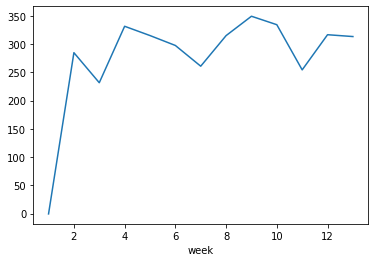

In [45]:
a.groupby('week')['z'].sum().plot()

In [46]:
pd.pivot_table(a, index='owner_id', columns='week', values='z', aggfunc='sum')

week,1,2,3,4,5,6,7,8,9,10,11,12,13
owner_id,,,,,,,,,,,,,
1,-9.905422,21.184369,30.026340,31.723211,11.359781,21.942149,21.018958,8.195562,14.033919,30.516233,36.199901,-12.818948,25.656895
3,-9.431754,3.925242,4.463447,13.931202,33.895033,23.799159,7.141683,24.732373,28.669588,49.152136,-3.752944,27.196426,19.687677
4,-10.242581,23.009961,11.641761,54.338512,15.394394,20.815248,24.130934,20.197274,19.212976,14.168596,16.918053,26.224525,10.313612
29,8.809798,30.476398,26.488546,25.073636,12.609000,12.797493,6.907573,10.041287,10.857142,-1.082350,-8.754257,18.321889,33.736293
30,-8.695294,73.401440,12.163690,16.423400,32.084245,33.272148,-9.606074,14.128467,15.044797,40.274803,22.774671,55.804277,19.539153
36,55.759661,36.932295,87.040415,73.773882,92.147374,73.110914,95.997731,56.354030,117.880249,88.931478,48.852904,49.314166,110.870288
38,-2.526910,29.780669,14.469687,37.107233,24.289169,30.490208,35.586298,42.366850,32.265034,23.957214,38.379011,52.112472,32.088046
41,-12.609048,9.459471,10.397076,16.546932,30.824619,12.842573,19.491967,40.291609,14.793405,36.218521,31.944140,17.723921,19.594421
42,1.756499,-5.164432,17.109345,10.168206,25.124538,12.200970,26.590646,37.787105,13.827708,10.043946,11.413665,31.343049,27.966922


In [ ]:
pd.read_sql("SELECT z.cbsid, p.CBSNAME player, o.owner, d.paid, ROUND(z*4.18,1) value, ROUND(z*4.18-d.paid,1) surplus, ROUND(z,2) z, \
            R, RBI, HR, SB, AB, BA_cnt, BA, IP, W, SO, t.SvHld, ERA, ERA_cnt, WHIP, WHIP_cnt, zR, zRBI, zHR, zSB, zBA \
        FROM vw_player_year_z z \
        LEFT JOIN players p On (z.cbsid=p.cbsid) \
        INNER JOIN vw_player_year_stats t On (z.cbsid=t.cbsid) \
        LEFT JOIN drafted d On (z.cbsid=d.cbsid) \
        LEFT JOIN owners o On (d.owner_id=o.owner_id) \
        WHERE z.year=2023 AND IP IS NULL \
        ORDER BY z desc", conn).head(10)#.z.sum()

In [ ]:
#conv = (self.tm_dollars/self.tm_players)*(self.tot_players/(h[h['z']>0]['z'].sum()+p[p['z']>0]['z'].sum()))
(260/23)*((1465)/2234.64)

In [ ]:
print(f"{round(260/23,2)} dollars per drafted player")
print(f"{23*12} total drafted players")
(260/23)*(276/506)

In [ ]:
#Could try dividing top z post season by top z pre season and diving all z scores by that number (1.95)

In [ ]:
pd.read_sql("SELECT name FROM sqlite_master", engine)

In [ ]:
pd.read_sql('SELECT * FROM players2023', conn)#.to_clipboard()

In [ ]:
units_of_value = 506 #650
((260*12)-(23*12)) / units_of_value

In [ ]:
pd.read_excel('data//2023-owner-weekly-sit-start.xlsx')

In [ ]:
e = pd.read_sql("WITH cte As (\
        SELECT e.cbsid, MAX(p.CBSNAME) name, MAX(e.week) maxWeek, max(e.pos1B) pos1B, max(pos2B) pos2B, max(pos3B) pos3B, max(posSS) posSS, max(posMI) posMI, max(posCI) posCI, \
            max(posOF) posOF, max(posDH) posDH, max(posSP) posSP, max(posRP) posRP, max(posP) posP \
        FROM eligibility e \
        INNER JOIN players p on (e.cbsid=p.cbsid) \
        GROUP BY e.cbsid) \
        SELECT cte.* FROM cte INNER JOIN eligibility e On (cte.cbsid=e.cbsid AND cte.maxWeek=e.week)", engine)

In [ ]:
e

### Turn projections into SQL tables

In [38]:
df = pd.read_csv("data\\2024-period-1-ros-projections.csv")
df.rename(columns={'Owner':'owner'}, inplace=True)
owners = pd.read_sql('SELECT * FROM owners', conn)
players = pd.read_sql('SELECT cbsid, CBSNAME Player, TEAM FROM Players', conn)
df = df.merge(owners, on='owner', how='left')

In [39]:
players

,cbsid,Player,TEAM
0,288897.0,Miguel Cabrera,DET
1,530355.0,Nelson Cruz,SD
2,547434.0,Joey Votto,CIN
3,1099374.0,Elvis Andrus,CHW
4,1103277.0,Michael Brantley,HOU
...,...,...,...
3556,2919567.0,Trevor Megill,MIL
3557,2837279.0,Andrew Nardi,MIA
3558,29313209.0,Yoshinobu Yamamoto,LAD
3559,26615406.0,Tink Hence,None


In [40]:
df.merge(players[['cbsid', 'Player']], on='Player', how='inner')

,Unnamed: 0,index,Avail,Player,AB,R,H,HR,RBI,BB,K,SB,CS,BA,OBP,SLG,Rank,Team,Pos,owner,top_50,top_100,top_276,above_276,Start,IP,APP,GS,QS,CG,W,L,S,BS,HD,SO,BBa,Ha,ERA,WHIP,Sv+Hld,ER,C,1B,2B,3B,SS,MI,CI,OF,DH,SP,RP,P,type,all_pos,zlgBA,zlgERA,zlgWHIP,zR,zHR,zRBI,zSB,zzlgBA,BIGAAh,zW,zSO,zSv+Hld,zzlgERA,zzlgWHIP,BIGAAp,z,owner_id,cbsid
0,0,0,9 Gran...,Trea Turner,602.0,97.0,175.0,23.0,79.0,41.0,135.0,34.0,4.0,0.291,0.339,0.480,14.0,PHI,SS,9 Grand Kids,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0,0,0,0,5,5,0,0,5,0,0,0.0,h,"['SS', 'MI', 'DH']",9.256092,NaN,NaN,1.360871,0.162927,0.302299,2.028340,0.892772,4.747208,NaN,NaN,NaN,NaN,NaN,0.000000,4.747208,30,2135249.0
1,1,1,9 Gran...,Ozzie Albies,544.0,88.0,154.0,27.0,98.0,44.0,106.0,12.0,2.0,0.283,0.343,0.505,28.0,ATL,2B,9 Grand Kids,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0,0,5,0,0,5,0,0,5,0,0,0.0,h,"['2B', 'MI', 'DH']",4.224774,NaN,NaN,0.791046,0.699626,1.456532,-0.016599,0.407490,3.338095,NaN,NaN,NaN,NaN,NaN,0.000000,3.338095,30,2167464.0
2,2,2,9 Gran...,Ketel Marte,545.0,83.0,157.0,24.0,79.0,58.0,113.0,10.0,3.0,0.288,0.360,0.501,46.0,ARI,2B,9 Grand Kids,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0,0,5,0,0,5,0,0,5,0,0,0.0,h,"['2B', 'MI', 'DH']",6.949452,NaN,NaN,0.474477,0.297101,0.302299,-0.202502,0.670291,1.541667,NaN,NaN,NaN,NaN,NaN,0.000000,1.541667,30,1963334.0
3,3,3,9 Gran...,Jeimer Candelario,481.0,80.0,131.0,27.0,77.0,59.0,146.0,8.0,2.0,0.272,0.364,0.534,57.0,CIN,"1B,3B",9 Grand Kids,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0,5,0,5,0,0,5,0,5,0,0,0.0,h,"['3B', '1B', 'CI', 'DH']",-1.429933,NaN,NaN,0.284535,0.699626,0.180801,-0.388406,-0.137920,0.638636,NaN,NaN,NaN,NaN,NaN,0.000000,0.638636,30,2051255.0
4,4,4,9 Gran...,Chas McCormick,460.0,64.0,128.0,19.0,73.0,43.0,125.0,21.0,6.0,0.278,0.353,0.459,66.0,HOU,OF,9 Grand Kids,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0,0,0,0,0,0,0,5,5,0,0,0.0,h,"['OF', 'DH']",1.351831,NaN,NaN,-0.728486,-0.373773,-0.062196,0.819967,0.130387,-0.214100,NaN,NaN,NaN,NaN,NaN,0.000000,-0.214100,30,2837198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,392,9,Young ...,Dane Dunning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,391.0,TEX,"RP,SP",Young Guns,0.0,0.0,0.0,1.0,0.0,150.0,26.0,26.0,12.0,0.0,10.0,5.0,0.0,0.0,0.0,125.0,50.0,139.0,3.54,1.26,0.0,59.000000,0,0,0,0,0,0,0,0,0,0,0,5.0,p,['P'],NaN,-16.466403,-12.081898,NaN,NaN,NaN,NaN,NaN,0.000000,0.231154,-0.451514,-0.536891,-0.292532,-1.114447,-2.164230,-2.164230,45,2250614.0
415,393,10,Young ...,Jose Berrios,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,406.0,TOR,SP,Young Guns,0.0,0.0,0.0,1.0,0.0,158.0,27.0,27.0,14.0,0.0,9.0,9.0,0.0,0.0,0.0,150.0,42.0,154.0,3.99,1.24,0.0,70.046667,0,0,0,0,0,0,0,0,0,0,0,5.0,p,['P'],NaN,-88.444612,-9.646266,NaN,NaN,NaN,NaN,NaN,0.000000,0.014070,0.121097,-0.536891,-1.571253,-0.889782,-2.862759,-2.862759,45,2044503.0
416,394,11,Young ...,MacKenzie Gore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,490.0,WAS,SP,Young Guns,0.0,0.0,0.0,1.0,0.0,144.0,27.0,27.0,8.0,0.0,8.0,9.0,0.0,0.0,0.0,150.0,54.0,140.0,3.88,1.35,0.0,62.080000,0,0,0,0,0,0,0,0,0,0,0,5.0,p,['P'],NaN,-64.767747,-24.158622,NaN,NaN,NaN,NaN,NaN,0.000000,-0.203013,0.121097,-0.536891,-1.150624,-2.228417,-3.997849,-3.997849,45,2835055.0
417,395,12,Young ...,Devin Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,552.0,MIL,RP,Young Guns,0.0,0.0,0.0,1.0,0.0,28.0,32.0,0.0,0.0,0.0,1.0,1.0,20.0,2.0,1.0,45.0,15.0,14.0,1.93,1.04,21.0,6.004444,0,0,0,0,0,0,0,0,0,0,0,5.0,p,['P'

In [16]:
df.columns

Index(['Unnamed: 0', 'index', 'Avail', 'Player', 'AB', 'R', 'H', 'HR', 'RBI',
       'BB', 'K', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'Rank', 'Team', 'Pos',
       'Owner', 'top_50', 'top_100', 'top_276', 'above_276', 'Start', 'IP',
       'APP', 'GS', 'QS', 'CG', 'W', 'L', 'S', 'BS', 'HD', 'SO', 'BBa', 'Ha',
       'ERA', 'WHIP', 'Sv+Hld', 'ER', 'C', '1B', '2B', '3B', 'SS', 'MI', 'CI',
       'OF', 'DH', 'SP', 'RP', 'P', 'type', 'all_pos', 'zlgBA', 'zlgERA',
       'zlgWHIP', 'zR', 'zHR', 'zRBI', 'zSB', 'zzlgBA', 'BIGAAh', 'zW', 'zSO',
       'zSv+Hld', 'zzlgERA', 'zzlgWHIP', 'BIGAAp', 'z'],
      dtype='object')

In [27]:
df[['Player', 'owner_id', 'Rank', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'Sv+Hld',
   'SO', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]

,Player,owner_id,Rank,AB,R,H,HR,RBI,BB,SB,BA,IP,W,Sv+Hld,SO,BBa,Ha,ERA,WHIP,ER,z
0,Trea Turner,30,14.0,602.0,97.0,175.0,23.0,79.0,41.0,34.0,0.291,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,4.747208
1,Ozzie Albies,30,28.0,544.0,88.0,154.0,27.0,98.0,44.0,12.0,0.283,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,3.338095
2,Ketel Marte,30,46.0,545.0,83.0,157.0,24.0,79.0,58.0,10.0,0.288,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,1.541667
3,Jeimer Candelario,30,57.0,481.0,80.0,131.0,27.0,77.0,59.0,8.0,0.272,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.638636
4,Chas McCormick,30,66.0,460.0,64.0,128.0,19.0,73.0,43.0,21.0,0.278,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,-0.214100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,Dane Dunning,45,391.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,150.0,10.0,0.0,125.0,50.0,139.0,3.54,1.26,59.000000,-2.164230
392,Jose Berrios,45,406.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,158.0,9.0,0.0,150.0,42.0,154.0,3.99,1.24,70.046667,-2.862759
393,MacKenzie Gore,45,490.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,144.0,8.0,0.0,150.0,54.0,140.0,3.88,1.35,62.080000,-3.997849
394,Devin Williams,45,552.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,28.0,1.0,21.0,45.0,15.0,14.0,1.93,1.04,6.004444,-1.984827
